In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows= 600000)

In [3]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows= 500000)

In [4]:
Train_nor, Test_nor = train_test_split(Nor_df, test_size=0.2, random_state=1)
Train_abnor, Test_abnor = train_test_split(Abnor_df, test_size=0.2, random_state=1) 

Train = pd.concat([Train_nor, Train_abnor], ignore_index=True)
Test = pd.concat([Test_nor, Test_abnor], ignore_index=True)

In [5]:
Train_4classes = Train_abnor[Train_abnor['label'].isin(['DoS_Gas', 'BP', 'OaU','FoT'])]

Train_3classes = Train_abnor[Train_abnor['label'].isin(['DoS', 'FoT','BP'])]

Train_2classes = Train_abnor[Train_abnor['label'].isin(['DoS','BP'])]

Train_1class = Train_abnor[Train_abnor['label'].isin(['OaU'])]

In [6]:
Train_DoS = Train_abnor[Train_abnor['label'].isin(['DoS'])]
Train_DoSGas = Train_abnor[Train_abnor['label'].isin(['DoS_Gas'])]
Train_FoT = Train_abnor[Train_abnor['label'].isin(['FoT'])]
Train_BP = Train_abnor[Train_abnor['label'].isin(['BP'])]
Train_OaU = Train_abnor[Train_abnor['label'].isin(['OaU'])]

In [7]:
Train_nor_unlab, Train_nor_lab = train_test_split(Train_nor,test_size=0.1, random_state=1)

In [8]:
Train_nor_lab.shape , Train_nor_unlab.shape

((48000, 29), (432000, 29))

In [9]:
Train_nor_lab = Train_nor_lab[:500]
Train_abnor_lab = Train_4classes[:500]

In [10]:
Train_nor_lab.shape, Train_abnor_lab.shape , Train_abnor_lab['label'].unique()

((500, 29), (500, 29), array(['DoS_Gas', 'FoT', 'OaU', 'BP'], dtype=object))

In [11]:
def one_hot_encode(data):
    unique_labels = [
    ["tcp", "udp", "icmp"],
    ["other", "private", "ecr_i", "urp_i", "urh_i", "red_i", "eco_i", "tim_i", "oth_i", "domain_u", "tftp_u", "ntp_u", "IRC", 
                "X11", "Z39_50", "aol", "auth", "bgp", "courier", "csnet_ns", "ctf", "daytime", "discard", "domain", "echo", "efs", "exec", 
                "finger", "ftp", "ftp_data", "gopher", "harvest", "hostnames", "http", "http_2784", "http_443", "http_8001", "icmp", "imap4",
                "iso_tsap", "klogin", "kshell", "ldap", "link", "login", "mtp", "name", "netbios_dgm", "netbios_ns", "netbios_ssn", "netstat",
                "nnsp", "nntp", "pm_dump", "pop_2", "pop_3", "printer", "remote_job", "rje", "shell", "smtp", "sql_net", "ssh", "sunrpc", 
                "supdup", "systat", "telnet", "time", "uucp", "uucp_path", "vmnet", "whois"],
    ["SF", "S0", "S1", "S2", "S3", "REJ", "RSTOS0", "RSTO", "RSTR", "SH", "RSTRH", "SHR", "OTH"],
    ["Normal","OaU","DoS","DoS_Gas","FoT","BP"]
    ]
    encoded_data = []
    # Thực hiện mã hóa one-hot
    for row in data:
        encoding = []
        for i, column_value in enumerate(row):
            unique_column_values = unique_labels[i]
            encoding.extend([1 if column_value == unique else 0 for unique in unique_column_values])
        encoded_data.append(encoding)
    return np.array(encoded_data)

In [12]:
encoder = OneHotEncoder( handle_unknown='ignore')
scaler = MinMaxScaler()

In [13]:
def preprocess_test(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    #df = df.drop(["label"], axis=1)
    df = df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    categorical_data = one_hot_encode(categorical_data)

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [14]:
#Dùng hàm preprocess_test
Train_nor = preprocess_test(Train_nor, True)
Train_abnor = preprocess_test(Train_abnor, False)

In [15]:
Train_nor_unlab = preprocess_test(Train_nor_unlab, True)
Train_nor_lab = preprocess_test(Train_nor_lab, True)
Train_abnor_lab = preprocess_test(Train_abnor_lab, False)

In [16]:
Train_nor_unlab['data'].shape, Train_nor_lab['data'].shape, Train_abnor_lab['data'].shape

((432000, 106), (500, 106), (500, 106))

In [17]:
Train_nor['data'].shape , Train_abnor['data'].shape

((480000, 106), (293936, 106))

In [18]:
test = preprocess_test(Test, False)
Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [259]:
Test_nor.shape , Test_abnor.shape

((120000, 106), (73484, 106))

In [19]:
Train_abnor_4clss = preprocess_test(Train_4classes, False)

Train_abnor_3clss = preprocess_test(Train_3classes, False)

Train_abnor_2clss = preprocess_test(Train_2classes, False)

Train_abnor_1clss = preprocess_test(Train_1class, False)

In [20]:
Train_DoS = preprocess_test(Train_DoS, False)
Train_BP = preprocess_test(Train_BP, False)
Train_DoSGas = preprocess_test(Train_DoSGas, False)
Train_FoT = preprocess_test(Train_FoT, False)
Train_OaU = preprocess_test(Train_OaU, False)


In [21]:
Train_abnor_4clss['data'].shape

(213767, 106)

In [22]:
Test_4class =  Test[Test['label'].isin(['DoS_Gas','FoT','BP','OaU','Normal'])]

Test_3class =  Test[Test['label'].isin(['FoT','DoS','BP'])]

Test_2class =  Test[Test['label'].isin(['DoS','BP','Normal'])]

Test_1class =  Test[Test['label'].isin(['OaU', 'Normal'])]

In [25]:
Test_4class['label'].unique()

array(['Normal', 'FoT', 'BP', 'DoS_Gas', 'OaU'], dtype=object)

In [26]:
# #Trường hợp 4 classes
# test = preprocess_test(Test_4class, False)
# Test_nor = test['data'][test['label'] == 'Normal']
# Test_abnor = test['data'][test['label'] == 'Abnormal']

In [249]:
# #Trường hợp 3 classes
# test = preprocess_test(Test_3class, False)
# Test_nor = test['data'][test['label'] == 'Normal']
# Test_abnor = test['data'][test['label'] == 'Abnormal']

In [24]:
# #Trường hợp 2 classes
# test = preprocess_test(Test_2class, False)
# Test_nor = test['data'][test['label'] == 'Normal']
# Test_abnor = test['data'][test['label'] == 'Abnormal']

In [18]:
# #Trường hợp 1 class
# test = preprocess_test(Test_1class, False)
# Test_nor = test['data'][test['label'] == 'Normal']
# Test_abnor = test['data'][test['label'] == 'Abnormal']

In [23]:
Train_labeled = np.concatenate((Train_nor_lab['data'],Train_abnor_lab['data']))
Labeled = np.concatenate((Train_nor_lab['label'],Train_abnor_lab['label']))
Labeled = np.where(Labeled == 'Normal', 0, 1)

In [24]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      keras.layers.Dense(input_dim, activation='tanh'),
      keras.layers.Dense(52, activation='tanh'),
      keras.layers.Dense(26, activation='tanh'),
      keras.layers.Dense(13, activation='tanh')
    ], name='encoder')
    self.decoder = keras.Sequential([
      keras.layers.Dense(26, activation='tanh'),
      keras.layers.Dense(52, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ], name='decoder')

    self.classifier = keras.Sequential([
      keras.layers.Dense(13, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
    ],name='classifier')

  def call(self, x, training=False):
    code = self.encoder(x)
    reconstruction = self.decoder(code)
    classification = self.classifier(code)
    return {'decoder_output': reconstruction, 'classifier_output': classification}

  
  def get_reconstruction_error(self, x, batch_size = 10000):
    r = self.predict(x, batch_size)
    return keras.metrics.mean_squared_error(x, r['decoder_output'])
  
  def get_classifier_prob(self, x, batch_size = 10000):
    pr = self.predict(x, batch_size)
    return pr['classifier_output'].reshape(-1)

  def predict_class(self, x, threshold,w1,w2, batch_size = 10000):
    reconstruction_error = self.get_reconstruction_error(x, batch_size)
    prob = self.get_classifier_prob(x,batch_size)
    anomaly_score = w1*reconstruction_error + w2*prob
    return np.where(anomaly_score <= threshold, 'Normal', 'Abnormal')

In [25]:
model = Autoencoder(Train_nor_unlab['data'].shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={'decoder_output': 'mse'},
)

In [26]:
model_path = 'Model/AE_500.model'
model.load_weights(model_path)

In [116]:
# model.fit(
#     x=Train_nor_unlab['data'],
#     y={'decoder_output': Train_nor_unlab['data']},
#     batch_size=256,
#     epochs=500,
#     shuffle=True
# )

Epoch 1/500
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0492 - decoder_output_loss: 0.0492
Epoch 2/500
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0197 - decoder_output_loss: 0.0197
Epoch 3/500
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0106 - decoder_output_loss: 0.0106
Epoch 4/500
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0041 - decoder_output_loss: 0.0041
Epoch 5/500
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0021 - decoder_output_loss: 0.0021
Epoch 6/500
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0013 - decoder_output_loss: 0.0013
Epoch 7/500
1688/1688 [==============================] - 5s 3ms/step - loss: 8.7814e-04 - decoder_output_loss: 8.7814e-04
Epoch 8/500
1688/1688 [==============================] - 5s 3ms/step - loss: 5.7582e-04 - decoder_output_loss: 5.7582e-04
Epoch 9/500
1688/1688 [==============================] - 5s 3ms/step - l

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={'decoder_output': 'mse', 'classifier_output': 'binary_crossentropy'},
    #loss_weights={'decoder_output': 1, 'classifier_output': 1.5},
    metrics={'classifier_output': 'accuracy'}
)

In [28]:
model.fit(
    x=Train_labeled,
    y={'decoder_output': Train_labeled, 'classifier_output': Labeled},
    batch_size=64,
    epochs=200,
    shuffle=True
)

Epoch 1/200
16/16 [==============================] - 3s 3ms/step - loss: 0.4809 - classifier_output_loss: 0.4720 - decoder_output_loss: 0.0088 - classifier_output_accuracy: 0.8690 
Epoch 2/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3470 - classifier_output_loss: 0.3314 - decoder_output_loss: 0.0156 - classifier_output_accuracy: 0.9020
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 0.3066 - classifier_output_loss: 0.2908 - decoder_output_loss: 0.0157 - classifier_output_accuracy: 0.9020
Epoch 4/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2903 - classifier_output_loss: 0.2758 - decoder_output_loss: 0.0145 - classifier_output_accuracy: 0.9030
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2795 - classifier_output_loss: 0.2659 - decoder_output_loss: 0.0136 - classifier_output_accuracy: 0.9020
Epoch 6/200
16/16 [==============================] - 0s 3ms/step - loss: 0.2648 - classifier_output

In [235]:
#model.save('Model/AE_500.model', save_format='tf')  # The file needs to end with the .keras extension

# model_path = 'Model/AE_fullclass_200_new.model'
# model.load_weights(model_path)

In [29]:
train_normal_re = model.get_reconstruction_error(Train_nor['data'], batch_size=10000)
train_abnormal_re = model.get_reconstruction_error(Train_abnor_4clss['data'], batch_size=10000)

test_normal_re = model.get_reconstruction_error(Test_nor, batch_size=10000)
test_abnormal_re = model.get_reconstruction_error(Test_abnor, batch_size=10000)

8/8 [==============================] - 0s 12ms/step


In [30]:
anomaly_scores_nor = 0.6 * train_normal_re + 0.4 * model.get_classifier_prob(Train_nor['data'])
anomaly_scores_abnor = 0.6 * train_abnormal_re + 0.4* model.get_classifier_prob(Train_abnor_4clss['data'])

22/22 [==============================] - 0s 13ms/step


In [31]:
anomaly_scores_nor

<tf.Tensor: shape=(480000,), dtype=float32, numpy=
array([7.4005447e-04, 3.5647410e-01, 1.9824183e-01, ..., 4.6437318e-04,
       7.5907103e-04, 5.3909975e-05], dtype=float32)>

In [32]:
sigma = 5
alpha = 0.5

In [33]:
sigma_threshold = np.percentile(anomaly_scores_nor, 100 - sigma)
sigma_threshold

0.3591022402048111

In [66]:
threshold = np.concatenate([anomaly_scores_nor,anomaly_scores_abnor]).mean() * alpha
print('Ngưỡng vừa tìm được:', threshold)

Ngưỡng vừa tìm được: 0.07139948010444641


In [36]:
train = np.concatenate((Train_nor['data'], Train_abnor_4clss['data']), axis=0)
label = np.concatenate((Train_nor['label'], Train_abnor_4clss['label']), axis=0)
train_fullclss = np.concatenate((Train_nor['data'], Train_abnor['data']), axis=0)
label_fullclss = np.concatenate((Train_nor['label'], Train_abnor['label']), axis=0)

# Kết quả trước khi threshold qua vòng tối ưu 

In [67]:
Nor_P = model.predict_class(Train_nor['data'],threshold,0.6,0.4,batch_size=10000)
acc_Nor = accuracy_score(Train_nor['label'],Nor_P)
print("Acc AE với tập train",acc_Nor)

48/48 [==============================] - 1s 10ms/step
Acc AE với tập train 0.8304520833333333


In [68]:
#new attack
DoS_P = model.predict_class(Train_DoS['data'],threshold,0.6,0.4,batch_size=10000)
acc_DoS = accuracy_score(Train_DoS['label'], DoS_P)
print("Acc AE với tập train",acc_DoS)

9/9 [==============================] - 0s 9ms/step
Acc AE với tập train 0.5951552345669773


In [69]:
DoS_Gas_P = model.predict_class(Train_DoSGas['data'],threshold,0.6,0.4,batch_size=10000)
acc_DoSGas = accuracy_score(Train_DoSGas['label'], DoS_Gas_P)
print("Acc AE với tập train",acc_DoSGas)

8/8 [==============================] - 0s 9ms/step
Acc AE với tập train 0.9959751088643762


In [70]:
OaU_P = model.predict_class(Train_OaU['data'],threshold,0.6,0.4,batch_size=10000)
acc_OaU = accuracy_score(Train_OaU['label'], OaU_P)
print("Acc AE với tập train",acc_OaU)

5/5 [==============================] - 0s 9ms/step
Acc AE với tập train 0.9827505941734251


In [71]:
FoT_P = model.predict_class(Train_FoT['data'],threshold,0.6,0.4,batch_size=10000)
acc_FoT = accuracy_score(Train_FoT['label'], FoT_P)
print("Acc AE với tập train",acc_FoT)

8/8 [==============================] - 0s 10ms/step
Acc AE với tập train 0.9944313048266196


In [72]:
BP_P = model.predict_class(Train_BP['data'],threshold,0.6,0.4,batch_size=10000)
acc_BP = accuracy_score(Train_BP['label'], BP_P)
print("Acc AE với tập train",acc_BP)

3/3 [==============================] - 0s 6ms/step
Acc AE với tập train 0.9854292205867826


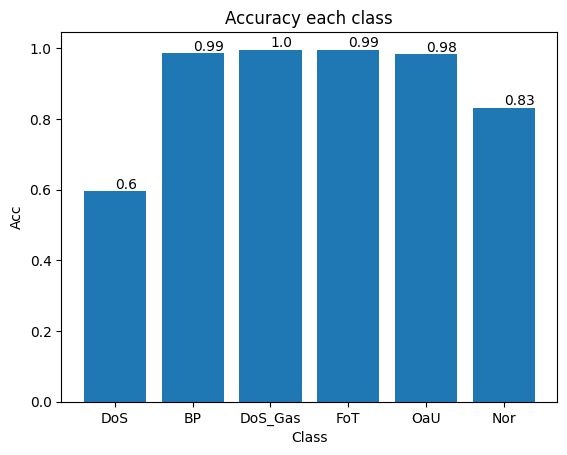

In [73]:
values = [acc_DoS, acc_BP, acc_DoSGas, acc_FoT, acc_OaU, acc_Nor]

labels = ['DoS', 'BP', 'DoS_Gas', 'FoT', 'OaU', 'Nor']
bars = plt.bar(labels, values)
plt.xlabel('Class')
plt.ylabel('Acc')
plt.title('Accuracy each class')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.show()

In [61]:
DoS_re = model.get_reconstruction_error(Train_DoSGas['data'], batch_size=10000)
anomaly_DoS = DoS_re * 0.5 + 0.5 * model.get_classifier_prob(Train_DoSGas['data'],batch_size=10000)

8/8 [==============================] - 0s 11ms/step


In [53]:
P_CL = model.predict_class(train,threshold,0.6,0.4,batch_size=10000)
print("Acc AE với tập train 4 class",accuracy_score(label, P_CL)) 
#AE: 4 class attack 89,493% , full class attack 89,956% / Classifier 4 clss 87,54% , full class attack 88,805%
# Bỏ DoS: AE 4 class 87,85% , full class 84,9 / Clf 4 class 88,01 , full class 82,19 (chưa tối ưu ngưỡng)
P_CL2 = model.predict_class(train_fullclss,threshold,0.6,0.4,batch_size=10000)
print("Acc AE với tập train full class",accuracy_score(label_fullclss, P_CL2))

P_CL2 = model.predict_class(test['data'],threshold,0.6,0.4,batch_size=10000)
print("Acc AE với tập test full class",accuracy_score(test['label'], P_CL2))

70/70 [==============================] - 1s 13ms/step
Acc AE với tập train 4 class 0.8801903232641507
78/78 [==============================] - 1s 13ms/step
Acc AE với tập train full class 0.8413706042876931
20/20 [==============================] - 0s 13ms/step
Acc AE với tập test full class 0.8501994997002336


In [52]:
label_1 = np.where(label == 'Normal', 0, 1)
label_2 = np.where(label_fullclss == 'Normal', 0, 1)
label_3 = np.where(test['label'] == 'Normal', 0, 1)

y_pred = model.get_classifier_prob(train, batch_size=10000)
y_pred_binary = (y_pred > 0.5).astype(int)
acc_test = accuracy_score(label_1, y_pred_binary)
print("Acc Clf với tập train 4 class:",acc_test)

y_pred2 = model.get_classifier_prob(train_fullclss, batch_size=10000)
y_pred_binary2 = (y_pred2 > 0.5).astype(int)
acc_test2 = accuracy_score(label_2, y_pred_binary2)
print("Acc Clf với tập train full class:",acc_test2)

y_pred3 = model.get_classifier_prob(test['data'], batch_size=10000)
y_pred_binary3 = (y_pred3 > 0.5).astype(int)
acc_test3 = accuracy_score(label_3, y_pred_binary3)
print("Acc Clf với tập train full class:",acc_test3)

70/70 [==============================] - 1s 13ms/step
Acc Clf với tập train 4 class: 0.8919334589278533
78/78 [==============================] - 1s 13ms/step
Acc Clf với tập train full class: 0.8355316201856484
20/20 [==============================] - 0s 12ms/step
Acc Clf với tập train full class: 0.8344824378243162


In [55]:
threshold = threshold # Initial threshold
best_threshold = threshold      # Initial best threshold
step = 1e-3                     # Initial step
decay = 0.5                     # Decay rate
num_decay = 5                   # Number of decay times
pre = 0                         # Previous accuracy
cur = 1e-9                      # Current accuracy
best_acc = 1                    # Initial best accuracy
occ = 10                        # Occurence of the previous accuracy better than the current one
count = 0                       # Counter

for d_i in range (num_decay):
    for i in range (1000):
        pre = cur
        pred = model.predict_class(train,threshold,0.6,0.4, 10000)
        acc  = accuracy_score(label, pred)
        threshold = threshold + step
        cur = acc
        print("Accuracy:", acc, "\nThreshold:", threshold)

        # If the previous accuracy is better than the current one. Plus the counter and store the best threshold and accuracy
        if (pre > cur):
            count = count + 1
            cur = pre
            best_threshold = threshold - count*step
            best_acc = pre
        else:
            count = 0
            best_threshold = threshold
            continue

        if count == occ + 1:
            step = step * decay
            threshold = best_threshold
            count = 0
            cur = best_acc
            print("--------------------------------------------------")
            print("Best accuracy:", best_acc, "\nFinal threshold:", best_threshold)
            break    

70/70 [==============================] - 1s 12ms/step
Accuracy: 0.8801903232641507 
Threshold: 0.07239948010444641
70/70 [==============================] - 1s 13ms/step
Accuracy: 0.8803950029332615 
Threshold: 0.07339948010444641
70/70 [==============================] - 1s 13ms/step
Accuracy: 0.8806241865064207 
Threshold: 0.07439948010444641
70/70 [==============================] - 1s 12ms/step
Accuracy: 0.8807971552408805 
Threshold: 0.07539948010444641
70/70 [==============================] - 1s 13ms/step
Accuracy: 0.8810148075650759 
Threshold: 0.07639948010444642
70/70 [==============================] - 1s 12ms/step
Accuracy: 0.8812382255137532 
Threshold: 0.07739948010444642
70/70 [==============================] - 1s 12ms/step
Accuracy: 0.881416959872695 
Threshold: 0.07839948010444642
70/70 [==============================] - 1s 13ms/step
Accuracy: 0.8816288465724084 
Threshold: 0.07939948010444642
70/70 [==============================] - 1s 13ms/step
Accuracy: 0.881820553586434

# Kết quả sau khi tối ưu threshold

In [74]:
new_threshold = 0.1903994801044463

In [57]:
Nor_P = model.predict_class(Train_nor['data'],new_threshold,0.6,0.4,batch_size=10000)
acc_Nor = accuracy_score(Train_nor['label'],Nor_P)
print("Acc AE với tập train",acc_Nor)

#new attack
DoS_P = model.predict_class(Train_DoS['data'],new_threshold,0.6,0.4,batch_size=10000)
acc_DoS = accuracy_score(Train_DoS['label'], DoS_P)
print("Acc AE với tập train",acc_DoS)

DoS_Gas_P = model.predict_class(Train_DoSGas['data'],new_threshold,0.6,0.4,batch_size=10000)
acc_DoSGas = accuracy_score(Train_DoSGas['label'], DoS_Gas_P)
print("Acc AE với tập train",acc_DoSGas)

OaU_P = model.predict_class(Train_OaU['data'],new_threshold,0.6,0.4,batch_size=10000)
acc_OaU = accuracy_score(Train_OaU['label'], OaU_P)
print("Acc AE với tập train",acc_OaU)

FoT_P = model.predict_class(Train_FoT['data'],new_threshold,0.6,0.4,batch_size=10000)
acc_FoT = accuracy_score(Train_FoT['label'], FoT_P)
print("Acc AE với tập train",acc_FoT)

BP_P = model.predict_class(Train_BP['data'],new_threshold,0.6,0.4,batch_size=10000)
acc_BP = accuracy_score(Train_BP['label'], BP_P)
print("Acc AE với tập train",acc_BP)

48/48 [==============================] - 0s 10ms/step
Acc AE với tập train 0.8632416666666667
9/9 [==============================] - 0s 9ms/step
Acc AE với tập train 0.5919869276154125
8/8 [==============================] - 0s 9ms/step
Acc AE với tập train 0.9623610863085017
5/5 [==============================] - 0s 8ms/step
Acc AE với tập train 0.920736039987259
8/8 [==============================] - 0s 10ms/step
Acc AE với tập train 0.9666879403336212
3/3 [==============================] - 0s 6ms/step
Acc AE với tập train 0.9578188284105502


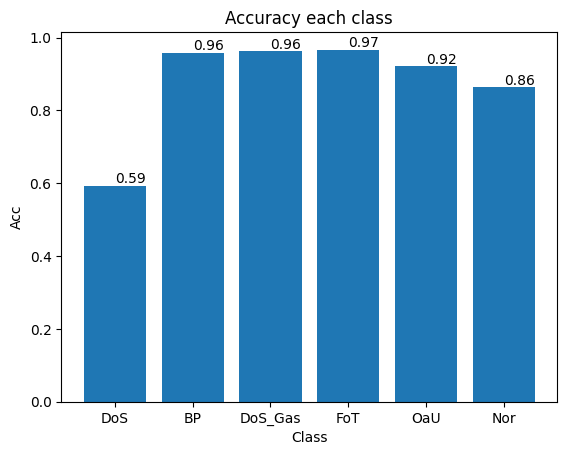

In [58]:
values = [acc_DoS, acc_BP, acc_DoSGas, acc_FoT, acc_OaU, acc_Nor]

labels = ['DoS', 'BP', 'DoS_Gas', 'FoT', 'OaU', 'Nor']
bars = plt.bar(labels, values)
plt.xlabel('Class')
plt.ylabel('Acc')
plt.title('Accuracy each class')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.show()

In [75]:
P_CL = model.predict_class(train,new_threshold,0.6,0.4,batch_size=10000)
print("Acc AE với tập train 4 class",accuracy_score(label, P_CL)) 

P_CL2 = model.predict_class(train_fullclss,new_threshold,0.6,0.4,batch_size=10000)
print("Acc AE với tập train full class",accuracy_score(label_fullclss, P_CL2))

P_CL2 = model.predict_class(test['data'],new_threshold,0.6,0.4,batch_size=10000)
print("Acc AE với tập test full class",accuracy_score(test['label'], P_CL2))

70/70 [==============================] - 1s 10ms/step
Acc AE với tập train 4 class 0.8916999511363325
78/78 [==============================] - 1s 10ms/step
Acc AE với tập train full class 0.8355613384052428
20/20 [==============================] - 0s 9ms/step
Acc AE với tập test full class 0.8604949246449319


In [29]:
a = tf.concat([train_normal_re,train_abnormal_re], axis = 0)
a= a.numpy()
a = a.reshape(-1, 1)

In [30]:
label_mapping = {"Normal": 0, "Abnormal": 1}
label_z = [label_mapping[label] for label in label]
label_z = np.array(label_z)
label_z.shape

(773936,)

In [31]:
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(a,label_z, test_size=0.2, random_state=42)

In [39]:
X_train_re.shape, X_test_re.shape, y_train_re.shape, y_test_re.shape

((619148, 1), (154788, 1), (619148,), (154788,))

In [109]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_re, X_test_re, y_train_re, y_test_re)

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [17:54:19<1:19:17, 4757.66s/it] 

[LightGBM] [Info] Number of positive: 235148, number of negative: 384000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 619148, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.379793 -> initscore=-0.490427
[LightGBM] [Info] Start training from score -0.490427


100%|██████████| 29/29 [17:54:21<00:00, 2222.82s/it]  


In [110]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.73,0.66,0.66,0.70,19.21
LGBMClassifier,0.73,0.66,0.66,0.70,1.74
Perceptron,0.72,0.65,0.65,0.69,0.50
AdaBoostClassifier,0.73,0.65,0.65,0.69,17.23
ExtraTreesClassifier,0.72,0.65,0.65,0.68,47.71
RandomForestClassifier,0.72,0.65,0.65,0.68,123.21
BaggingClassifier,0.72,0.64,0.64,0.68,12.76
KNeighborsClassifier,0.69,0.64,0.64,0.68,8.78
DecisionTreeClassifier,0.72,0.64,0.64,0.68,1.60


In [90]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.66,0.66,0.66,0.65,8.14
LGBMClassifier,0.65,0.65,0.65,0.64,0.49
AdaBoostClassifier,0.65,0.65,0.65,0.62,3.55
DecisionTreeClassifier,0.63,0.63,0.63,0.60,0.47
RandomForestClassifier,0.63,0.63,0.63,0.60,30.06
BaggingClassifier,0.63,0.63,0.63,0.60,3.28
LogisticRegression,0.62,0.63,0.63,0.57,0.14
KNeighborsClassifier,0.63,0.63,0.63,0.62,1.92
Perceptron,0.62,0.62,0.62,0.57,0.09


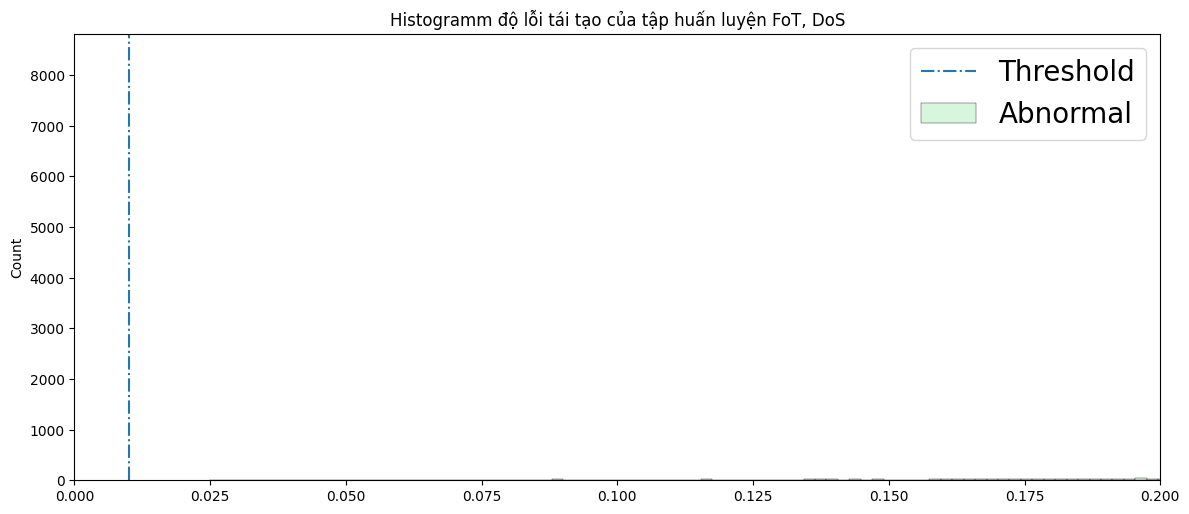

In [63]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
#sns.histplot(data=anomaly_scores_nor, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=anomaly_DoS, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(0.01, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện FoT, DoS')
plt.show()

# Variational AE test

In [ ]:
class VAE(keras.Model):
    def __init__(self, input_dim, latent_dim=13):
        super(VAE, self).__init__()
        
        self.encoder = keras.Sequential([
            keras.layers.Dense(input_dim, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(100, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(52, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(32, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(latent_dim*2, activation='linear')
        ], name='encoder')
        
        self.decoder = keras.Sequential([
            keras.layers.Dense(32, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(52, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(100, activation='tanh'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(input_dim, activation='sigmoid'),
        ], name='decoder')

        
    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        return self.decoder(z)
    
    def reconstruct(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        
        return reconstructed
    
    def call(self, inputs,training = True):
        if training:
            mean, logvar = self.encode(inputs)
            z = self.reparameterize(mean, logvar)
            reconstructed = self.decode(z)
            return {'decoder_output': reconstructed, 'mean': mean, 'logvar': logvar}
        else:
            mean, logvar = self.encode(inputs)
            z = self.reparameterize(mean, logvar)
            reconstructed = self.decode(z)
            return reconstructed

# Loss function
def vae_loss(x, decoded, mean, logvar):
    reconstruction_loss = keras.losses.mean_squared_error(x, decoded)
    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss) , kl_loss, reconstruction_loss

# Compile and train the VAE
vae = VAE(input_dim=Train_nor['data'].shape[1])
vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(Train_nor['data'])
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(512)

def train_step(x):
    with tf.GradientTape() as tape:
        outputs = vae(x)
        loss, kl_loss, res = vae_loss(x, outputs['decoder_output'], outputs['mean'], outputs['logvar'])
        loss = tf.reduce_mean(loss)
    #print("finished loss")
    # Tính toán gradients
    grads = tape.gradient(loss, vae.trainable_weights)
    #print("apply optimizer")
    # Update weights
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    return loss, tf.reduce_mean(kl_loss), tf.reduce_mean(res)

epochs = 300
for epoch in range(epochs):
    for step, x_batch_train in enumerate(train_dataset):
        #print(f'Step: {step}, Batch shape: {x_batch_train.shape}')
        loss, kl_loss, res = train_step(x_batch_train)
    print(f'Epoch: {epoch+1}, Loss: {loss.numpy()}, KL_Loss: {kl_loss.numpy()}, Res_loss: {res.numpy()}')

In [ ]:
def calculate_anomaly_score(x, decoded, mean, logvar, beta):
    reconstruction_error = keras.losses.mean_squared_error(x, decoded)
    kl_divergence = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)
    
    anomaly_score = reconstruction_error + beta * kl_divergence
    return anomaly_score